In [1]:
 #pip install gurobipy

In [2]:
# Import packages
import gurobipy as gp
from gurobipy import nlfunc
from gurobipy import GRB
import pandas as pd
import numpy as np
import json

# Data Inputs


In [3]:


# load JSONs
with open('../data/question_1c/bus_params.json', 'r') as file:
    bus_params = json.load(file)
#print(json.dumps(bus_params, indent=4))
with open('../data/question_1c/DER_production.json', 'r') as file:
    der_production = json.load(file)
#print(json.dumps(der_production, indent=4))

with open('../data/question_1c/appliance_params.json', 'r') as file:
    appl_params= json.load(file)
#print(json.dumps(appl_params, indent=4))

with open('../data/question_1c/usage_preferences.json', 'r') as file:
    usage_preference= json.load(file)
#print(json.dumps(usage_preference, indent=4))


# Read relevant fields from JSONs

# Lmin_t : minimum hourly flexible load (kWh/h). Lmint = 0 here because the load is fully flexible.
Lmin_t = 0.0
# Lmax_t : maximum hourly flexible load (kWh/h).
Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"]
# Pt_PV : Hourly available PV production (kWh/h).
Pt_PV = der_production[0]["hourly_profile_ratio"]
# pt: electricity price (DKK/kWh).
pt = bus_params[0]["energy_price_DKK_per_kWh"]


#Lt_ref : reference hourly profile of preferred consumption (kWh).
Lt_ref = usage_preference[0]["load_preferences"][0]["hourly_profile_ratio"] 

#gt_imp_max and gt_exp_max
max_import_kW = bus_params[0]["max_import_kW"]
max_export_kW = bus_params[0]["max_export_kW"]

#tau_imp and tau_export : are the tariffs per hour? (DKK/kWh)
tau_imp = bus_params[0]["import_tariff_DKK/kWh"]
tau_exp = bus_params[0]["export_tariff_DKK/kWh"]

# Battery parameters:
# Emax: Energy storage capacity (kWh).
Emax = appl_params["storage"][0]["storage_capacity_kWh"]

# maximum charging/discharging power (kWh/h). 
chrg_ratio = appl_params["storage"][0]["max_charging_power_ratio"]
Pt_chrg_max = chrg_ratio * Emax
dischrg_ratio = appl_params["storage"][0][ "max_discharging_power_ratio"]
Pt_dischrg_max = dischrg_ratio * Emax

# ηch, ηdis: charging and discharging efficiencies.
eff_ch = appl_params["storage"][0]["charging_efficiency"]
eff_dis = appl_params["storage"][0]["discharging_efficiency"]

## Decision Variables


In [4]:

# Make model
model = gp.Model("Model")
n_hours = 24
HOURS = list( range(n_hours))


## deafult upper bound and lower bound of each variable
lb = 0.0
ub = float('inf')

# quantifies price of not adhereing to refernce profile
alpha = 10
bt_E0 = 0.5 * Emax

# Lt: load consumption (kWh).
Lt = {t: model.addVar(Lmin_t, Lmax_t,vtype=GRB.CONTINUOUS, name='L{0}'.format(t)) for t in HOURS}

#ut: Energy not curtailed (kWh).
ut= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='s{0}'.format(t)) for t in HOURS}

# ct: PV curtailed (kWh).
ct = {t: model.addVar(lb, ub,vtype=GRB.CONTINUOUS, name='c{0}'.format(t)) for t in HOURS}

# gt_imp : grid import (kWh).
gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name='g{0}_imp'.format(t)) for t in HOURS}

# gt_exp : grid export (kWh).
gt_exp = {t: model.addVar(lb, max_export_kW,vtype=GRB.CONTINUOUS, name='g{0}_exp'.format(t)) for t in HOURS}

# HCt: Hourly Cost (DKK) # can be negative! if we earn money!
HCt = {t: model.addVar(-ub, ub,vtype=GRB.CONTINUOUS, name='HC{0}'.format(t)) for t in HOURS}

# Dt: Discomfort (kWh)
Dt = {t: model.addVar(0, ub,vtype=GRB.CONTINUOUS, name='D{0}'.format(t)) for t in HOURS}

# bt_ch : battery charging (kWh)
bt_ch = {t: model.addVar(0, Pt_chrg_max,vtype=GRB.CONTINUOUS, name='b{0}_ch'.format(t)) for t in HOURS}

# bt_dis : battery discharging (kWh)
bt_dis = {t: model.addVar(0, Pt_dischrg_max,vtype=GRB.CONTINUOUS, name='b{0}_dis'.format(t)) for t in HOURS}

# Et: battery state-of-charge (kWh)
Et = {t: model.addVar(0, Emax,vtype=GRB.CONTINUOUS, name='E{0}_bt'.format(t)) for t in HOURS}



model.update()
vars = model.getVars()
print("added " +str(len(vars)) + " variables")


Restricted license - for non-production use only - expires 2026-11-23
added 240 variables


# Constraints
Note: value bound constraints are modeled in the definition of the variable assignments, using their minimum and maximum range values (default 0 to infinity unless not specified)

In [ ]:

#need to add these before loop
# (Cyclic Condition)
model.addLConstr(Et[0], GRB.EQUAL , Et[n_hours-1], name='Value E0') # 23 bc we are going t0-23
# (Battery depletion limit) E24 > 0 (22)
model.addLConstr(Et[n_hours-1], GRB.GREATER_EQUAL , 0, name='Battery depletetion E24') # 23 bc we are going t0-23

for t in HOURS :
    # (PV allocation) ut + ct = Pt_PV
    model.addLConstr(ut[t] + ct[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation')
    
    # (Energy balance at consumer node)
    # updated to include battery charge/discharge
    model.addLConstr(ut[t] + gt_imp[t] + bt_dis[t], GRB.EQUAL , Lt[t] + gt_exp[t] + bt_ch[t], name='Energy_balance_at_node')
    
    #(Hourly Cost) HC = (pt + τt) gt_imp − (pt − τt)gt_exp
    model.addConstr((pt[t] + tau_imp) * gt_imp[t] - (pt[t] - tau_exp) * gt_exp[t] == HCt[t], name='Hourly cost')
    
    #(Discomfort) Dt = (Lt_ref − Lt)^2 #
    # model absolute distance with two constraints
    model.addConstr(Dt[t] >= Lt_ref[t] - Lt[t])
    model.addConstr(Dt[t] >= Lt[t] - Lt_ref[t])
    
    # Charge limit
    model.addLConstr(bt_ch[t] + Et[t], GRB.LESS_EQUAL ,Emax, name='Battery charge limit')
    # Discharge limit
    model.addLConstr(Et[t] - bt_dis[t], GRB.GREATER_EQUAL , 0, name='Battery Discharge limit')


     # t>0 because E0 is defined
    if t < n_hours-1 :
        # (Battery state-of-charge dynamics) Et = Et−1 + eff_ch * bt_ch − eff_dis*bt_dis
        model.addLConstr(Et[t] + eff_ch * bt_ch[t] - eff_dis*bt_dis[t], GRB.EQUAL ,Et[t+1], name='Battery charge and Discharge')


model.update()
print(str(model.getConstrs))

<bound method Model.getConstrs of <gurobi.Model Continuous instance Model: 194 constrs, 240 vars, No parameter changes>>


# Objective

In [6]:
model.setObjective(
    gp.quicksum(
        alpha * Dt[t] + HCt[t]
        for t in HOURS
    ), GRB.MINIMIZE)

In [7]:
# Optimize the model
model.optimize()

# Check the optimization status
if model.status == GRB.OPTIMAL:
    print("Optimization successful!")
    # You can access the optimal objective value and variable values here
    print("Optimal objective value:", model.ObjVal)
    for v in model.getVars():
        if v.X > 1e-6: # Print only variables with non-zero values
            print(v.VarName, v.X)
elif model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded")
else:
    print("Optimization ended with status", model.status)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 194 rows, 240 columns and 507 nonzeros
Model fingerprint: 0x6a0d0f92
Coefficient statistics:
  Matrix range     [4e-01, 3e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [9e-01, 1e+03]
  RHS range        [4e-02, 6e+00]
Presolve removed 131 rows and 162 columns
Presolve time: 0.00s
Presolved: 63 rows, 78 columns, 141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0800000e+03   1.500034e+04   0.000000e+00      0s
      51    1.1184550e+01   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.118455000e+01
Optimization successful!
Optimal objective value: 11.184550000000003
L0 0.055
L1 0.04
L2 0.04
L3 0.04
L4 0.075
L5 0.48

# Visualization


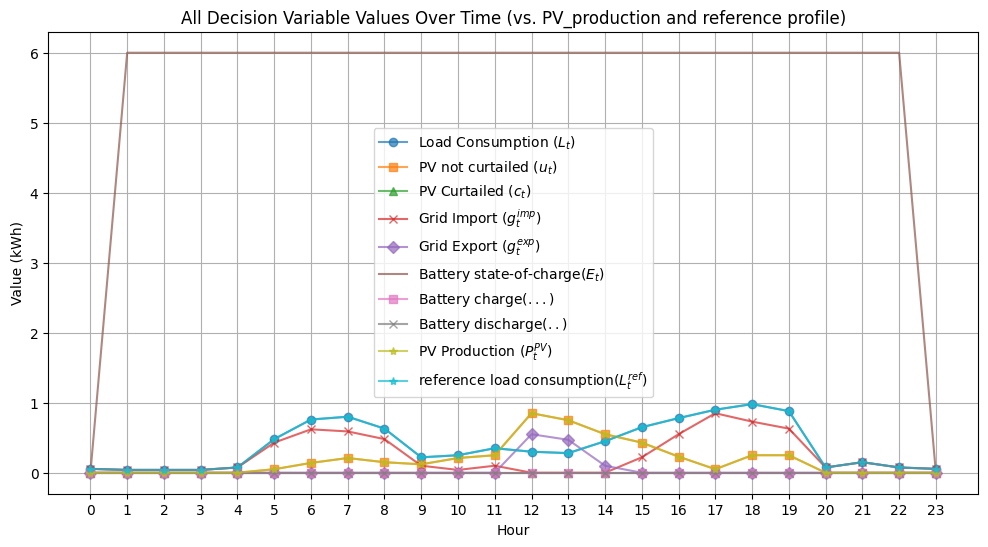

In [8]:
import matplotlib.pyplot as plt

Lt_values = [Lt[t].X for t in HOURS]
ut_values = [ut[t].X for t in HOURS]
ct_values = [ct[t].X for t in HOURS]
gt_imp_values = [gt_imp[t].X for t in HOURS]
gt_exp_values = [gt_exp[t].X for t in HOURS]
HCt_values = [HCt[t].X for t in HOURS]
Et_values = [Et[t].X for t in HOURS]
bt_ch_values = [bt_ch[t].X for t in HOURS]
bt_dis_values = [bt_dis[t].X for t in HOURS]


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(HOURS, Lt_values, label='Load Consumption ($L_t$)', alpha=0.7, marker='o')
plt.plot(HOURS, ut_values, label='PV not curtailed ($u_t$)', alpha=0.7, marker='s')
plt.plot(HOURS, ct_values, label='PV Curtailed ($c_t$)', alpha=0.7, marker='^')
plt.plot(HOURS, gt_imp_values, label='Grid Import ($g_t^{imp}$)', alpha=0.7, marker='x')
plt.plot(HOURS, gt_exp_values, label='Grid Export ($g_t^{exp}$)', alpha=0.7, marker='D')
plt.plot(HOURS, Et_values, label='Battery state-of-charge($E_t$)', alpha=0.7)
plt.plot(HOURS, bt_ch_values, label='Battery charge($...$)', alpha=0.7, marker='s')
plt.plot(HOURS, bt_dis_values, label='Battery discharge($..$)', alpha=0.7, marker='x')
Pt_PV = der_production[0]["hourly_profile_ratio"]
plt.plot(HOURS, Pt_PV, label='PV Production ($P_t^{PV}$)', alpha=0.7, marker='*')
plt.plot(HOURS, Lt_ref, label='reference load consumption($L_t^{ref}$)', alpha=0.7, marker='*')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Value (kWh)')
plt.title('All Decision Variable Values Over Time (vs. PV_production and reference profile)')
plt.xticks(HOURS)
plt.legend()
plt.grid(True)
plt.show()

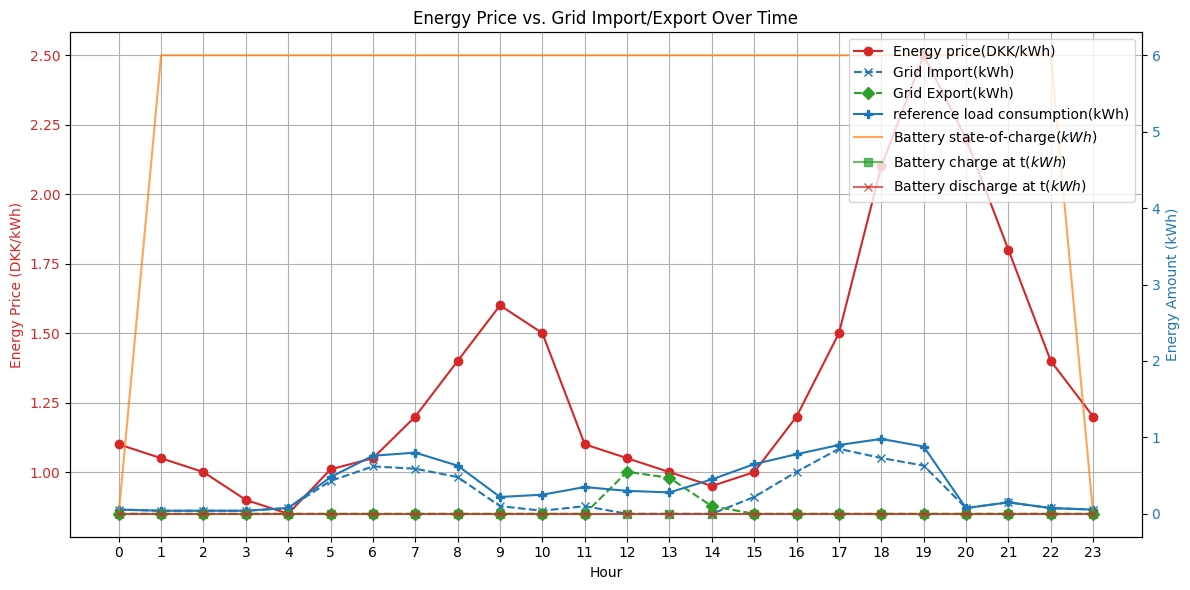

In [9]:
import matplotlib.pyplot as plt

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot energy price on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
ax1.plot(HOURS, pt, color=color, marker='o', label='Energy price(DKK/kWh)')
# ax1.plot(HOURS, np.repeat(tau_imp, 24), color='tab:orange',  label='Import tariff (DKK/kWh)')
# ax1.plot(HOURS, np.repeat(tau_exp, 24), color='tab:pink',  label='Export tariff (DKK/kWh)')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.plot(HOURS, HCt_values, color='tab:pink', label='Hourly cost (DKK)') 
ax1.grid(True)

# Create a second y-axis for import/export
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Energy Amount (kWh)', color=color)
ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import(kWh)')
ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export(kWh)')
ax2.plot(HOURS, Lt_ref, label='reference load consumption(kWh)', marker='P') 
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(HOURS, Et_values, label='Battery state-of-charge($kWh$)', alpha=0.7)
ax2.plot(HOURS, bt_ch_values, label='Battery charge at t($kWh$)', alpha=0.7, marker='s')
ax2.plot(HOURS, bt_dis_values, label='Battery discharge at t($kWh$)', alpha=0.7, marker='x')

# Add title and legend
plt.title('Energy Price vs. Grid Import/Export Over Time')
fig.tight_layout() # To prevent labels overlapping
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.xticks(HOURS)
plt.show()

# TODO i dont know why KWH axis doesnt start at zero